In [1]:
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

In [1]:
import os
if  not 'juxtorpus' in os.listdir():
    os.chdir('../../')
assert 'juxtorpus' in os.listdir(), f"Working directory should be at juxtorpus. But at {os.getcwd()}"
f"Working directory: {os.getcwd()}"

# imports
import pandas as pd
from pathlib import Path
import spacy
from juxtorpus.corpus import Corpus
from juxtorpus.corpus.processors import process
from juxtorpus.corpus.app import App
from juxtorpus.corpus.topic_model import LDA
from juxtorpus.viz.corpus import timeline, timelines, wordcloud, wordclouds
from juxtorpus.viz.item_timeline import ItemTimeline
from juxtorpus.matchers import is_hashtag

from juxtorpus import Jux
from juxtorpus.corpus.corpora import Corpora

import warnings
warnings.filterwarnings('ignore')


# Juxtorpus
## A fast demo on binderhub @ AARNet

# 1. Build a Corpus (Auspol Tweets dataset)

In [37]:
use_cols = ['id', 'created_at', 'source', 'location', 'text', 'retweet_count', 'lang', 'possibly_sensitive', 'tweet_type']
dtypes = ['Int64', 'category', 'string', 'Int64', 'category', 'category', 'category']

df = pd.read_csv(Path('./notebooks/demos/Sample_Auspol_Tweets_Full.csv'), 
                 usecols=use_cols, 
                 dtype={'id': 'Int64', 'source': 'category', 'location':str, 'text':str, 'retweet_count':int, 'lang': 'category', 'tweet_type': 'category'})
df['created_at'] = pd.to_datetime(df['created_at'])
corpus = process(Corpus.from_dataframe(df, col_doc='text', name='auspol'), nlp=spacy.blank('en'))
corpus.name = 'auspol'

In [38]:
corpora = Corpora()
corpora.add(corpus)
corpora.widget()

In [16]:
df.columns

Index(['id', 'created_at', 'from_user_name', 'source', 'location', 'text',
       'retweet_id', 'retweet_count', 'in_reply_to_status_id', 'lang',
       'possibly_sensitive', 'quoted_status_id', 'tweet_type'],
      dtype='object')

## Exploring the Corpus

In [4]:
corpus = corpora['auspol']
print('This table summarise the basic information of the corpus')
corpus.summary()

This table summarise the basic information of the corpus


Corpus Type                                                    SpacyCorpus
Number of Documents                                                 100000
Number of Total Words                                              1544294
Size of Vocabulary                                                   40469
mean Words per Document                                                 15
min Words per Document                                                   0
max Words per Document                                                  59
metas                    id, created_at, from_user_name, source, locati...

### Corpus Wordcloud

Generate a word cloud with one line of code


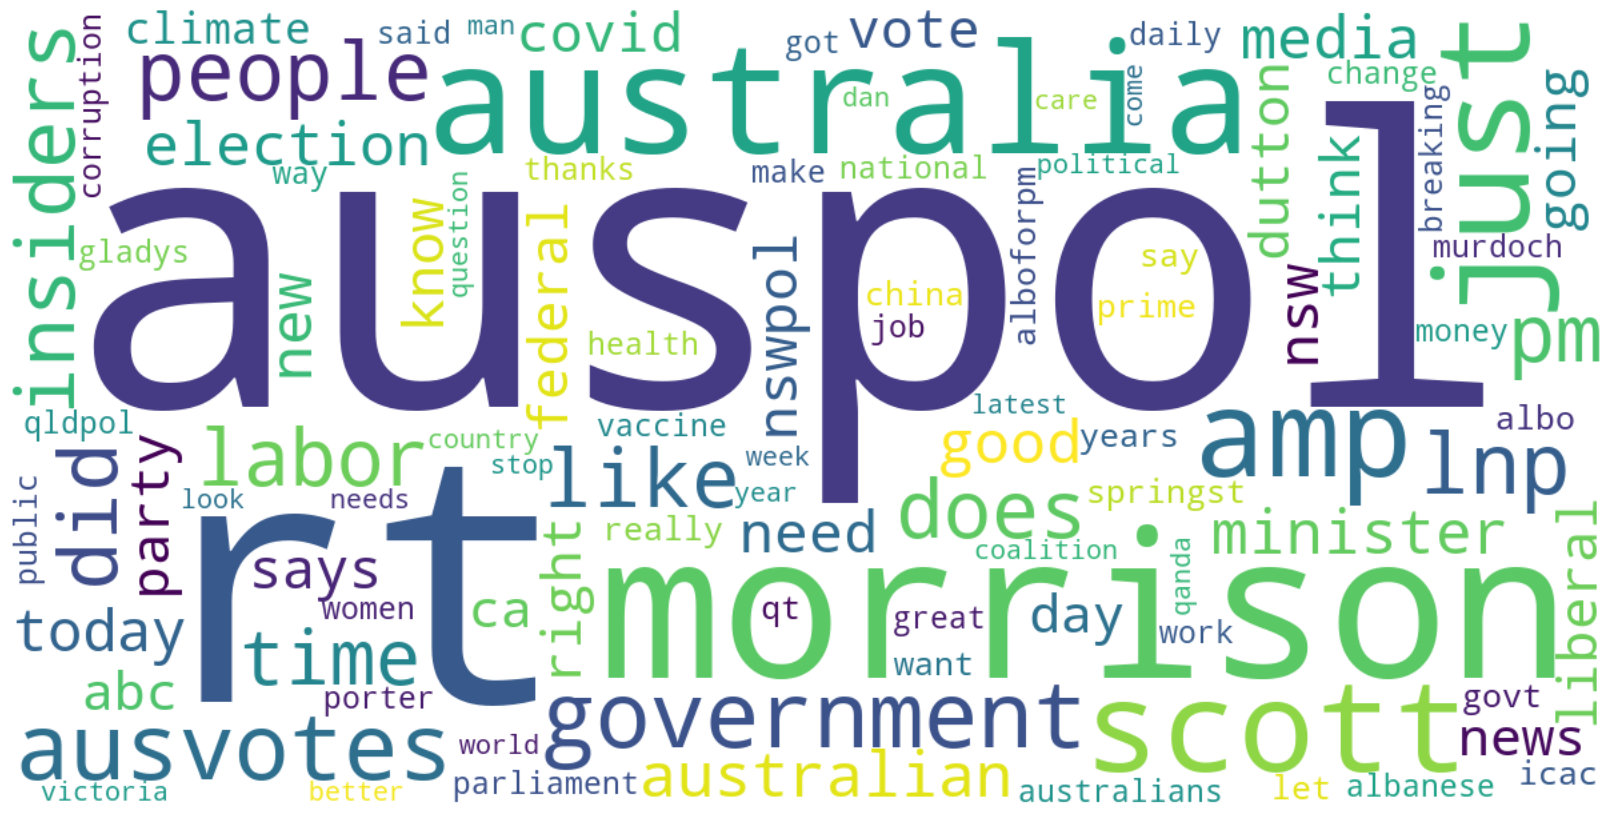

In [5]:
MAX_WORDS = 100
TYPE = 'word'
# TYPE = 'hashtag'
# TYPE = 'mention'
print('Generate a word cloud with one line of code')
corpus.viz.wordcloud(max_words=MAX_WORDS, word_type=TYPE)

Or make a wordcloud focusing on another predefined pattern - Hashtag


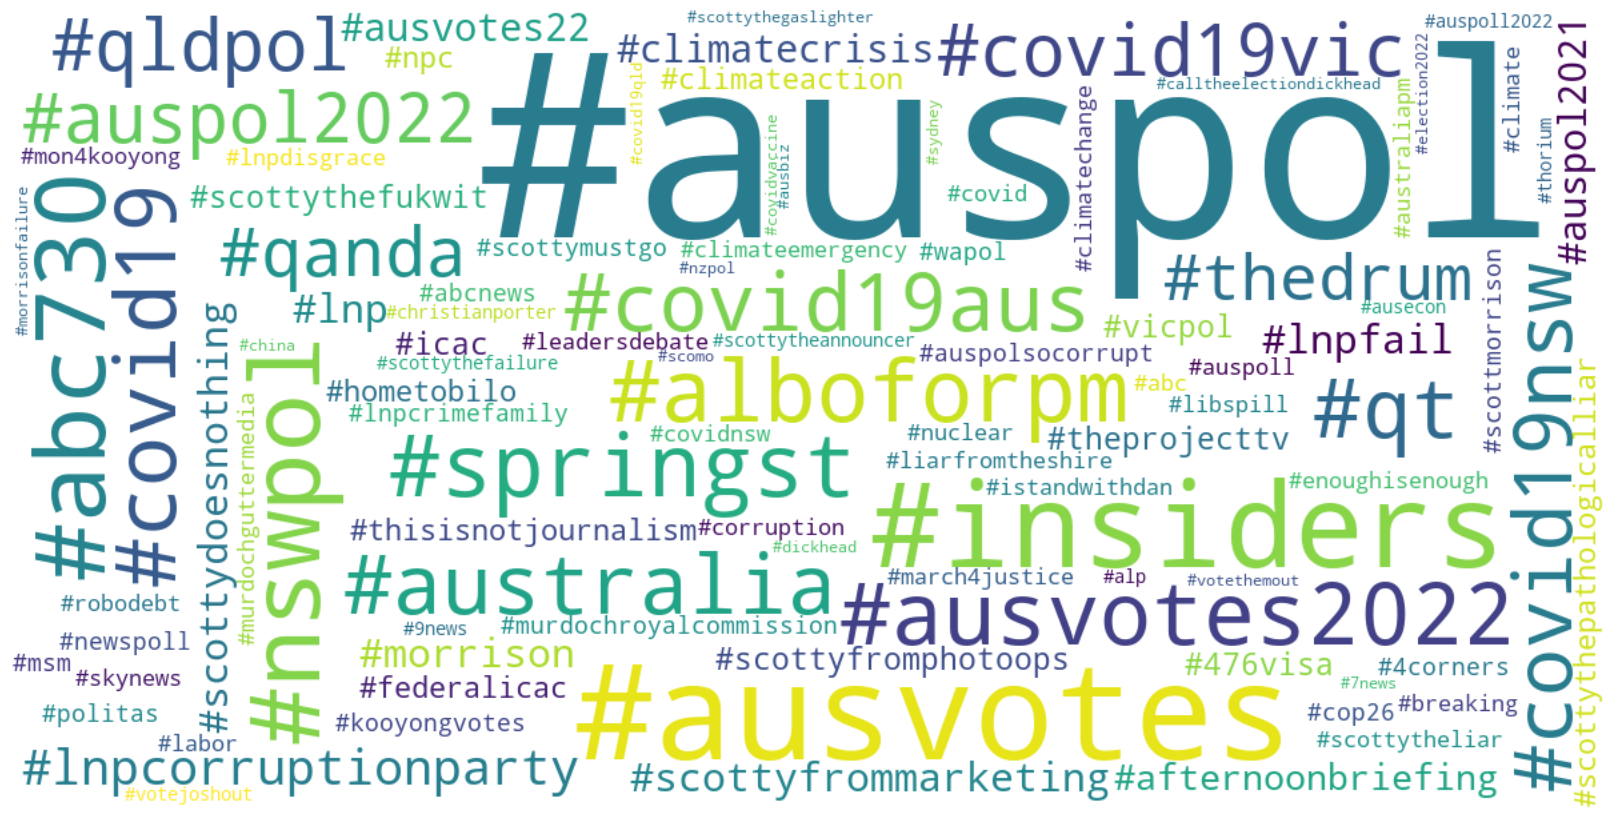

In [6]:
MAX_WORDS = 100
# TYPE = 'word'
TYPE = 'hashtag'
# TYPE = 'mention'
print('Or make a wordcloud focusing on another predefined pattern - Hashtag')
corpus.viz.wordcloud(max_words=MAX_WORDS, word_type=TYPE)

### A Timeline of Daily Tweets Number

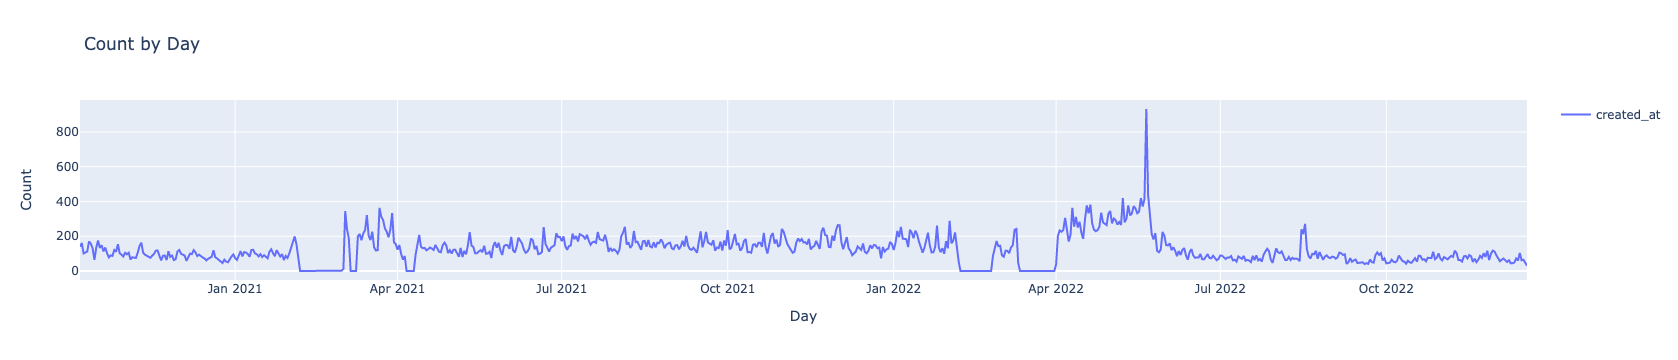

In [7]:
# FREQ = '1w'
# FREQ = '1m'
FREQ = '1d'
COL_TIME = 'created_at'
corpus.viz.timeline(COL_TIME, freq=FREQ)

Can also aggregate the data by different periods, e.g. weekly tweeting numbers


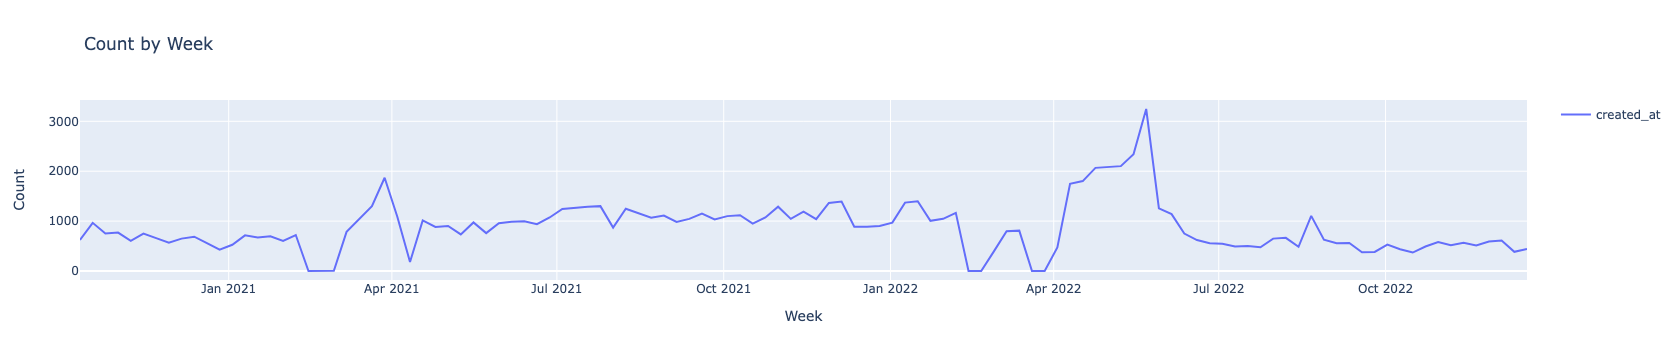

In [8]:
print('Can also aggregate the data by different periods, e.g. weekly tweeting numbers')
corpus.viz.timeline(COL_TIME, freq='1w')

In [11]:
COL_TIME = 'created_at'
FREQ = '1w'

# user defined function in creating a custom dtm (document-term-matrix)
matcher = is_hashtag(corpus.nlp.vocab)
def extract_hashtags(doc): return [doc[s:e].text.lower() for _, s, e in matcher(doc)]
corpus.create_custom_dtm(extract_hashtags)

print('Extract all Hashtags and display their weekly trends\n - Click legend to deselect items\n - Use the search box to display specific hashtag')
item_timeline = ItemTimeline.from_corpus(corpus, COL_TIME, FREQ, custom_dtm=True)
item_timeline.render()

Extract all Hashtags and display their weekly trends
 - Click legend to deselect items
 - Use the search box to display specific hashtag


FigureWidget({
    'data': [{'marker': {'color': 'rgba(126,115,0,1.0)'},
              'mode': 'lines+markers+…

# Corpus Slicer - creating a subcorpus

In [42]:
corpora.widget()

In [40]:
import re
corpus = corpora['auspol'].slicer.filter_by_condition('source', lambda src: re.match(r'^twitter.', src, re.IGNORECASE) is not None)

In [41]:
corpus.name

'auspol'

In [17]:
L_func = '''lambda x: re.match(r'^twitter for.', x, re.IGNORECASE) is not None'''
corpora['app'] = corpora['auspol'].slicer.filter_by_condition('source', eval(L_func))

In [33]:
code = '''
def A(x):
    return x+1

def B(x):
    return A(x) * A(x)
'''
#print(B(2))
exec(code)
print(exec('B(4)'))

None


In [28]:
A_func_code

<code object <lambda> at 0x2d103a810, file "/var/folders/1n/ynr0l5x95gx628r7xsnmn9c40000gq/T/ipykernel_9574/459941149.py", line 1>

In [15]:
corpora['auspol'].meta['source'].series.str.match(re.compile(r'Android'))

0        False
1        False
2        False
3        False
4        False
         ...  
99995    False
99996    False
99997    False
99998    False
99999    False
Name: source, Length: 100000, dtype: object

In [14]:
MAX_WORDS = 50
corpora['jun-orig-rt5+'].viz.wordcloud(max_words=MAX_WORDS)

AttributeError: 'NoneType' object has no attribute 'viz'

## Topic Modelling - Add results to your corpus

In [15]:
NUM_TOPICS = 10
lda = LDA(corpora['auspol-en'], num_topics=NUM_TOPICS).build('tf')
lda.add_results_to_corpus()
lda.widget()

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.008259 -0.016417       1        1  13.923700
8      0.039435 -0.056685       2        1  12.196447
0     -0.005570 -0.013098       3        1  11.881041
3      0.030283 -0.084517       4        1  10.879043
2      0.030721 -0.005928       5        1   9.937499
6      0.032692 -0.038692       6        1   9.731469
7      0.012573 -0.027983       7        1   9.656323
9     -0.012748 -0.018173       8        1   8.875498
1     -0.225892  0.054325       9        1   6.626725
4      0.090247  0.207167      10        1   6.292255, topic_info=             Term         Freq        Total Category  logprob  loglift
20914       scott  2344.000000  2344.000000  Default  30.0000  30.0000
15046    minister  1187.000000  1187.000000  Default  29.0000  29.0000
18471       prime   755.000000   755.000000  Default  28.0000  28.0000
18139      porter   848.000000   848.000000  Default  27.0000  27.0000
15374    morrison  7153.000000  7153.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1535    australia   142.825362  3149.606002  Topic10  -5.3047  -0.3276
13821         lnp   115.660707  1495.760656  Topic10  -5.5157   0.2061
16364      nswpol    90.267676   901.835241  Topic10  -5.7635   0.4642
24286        time    87.980443  1242.498673  Topic10  -5.7892   0.1181
10105  government    84.854662  2018.154572  Topic10  -5.8254  -0.4031

[796 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
20         1  0.043642   abc
20         2  0.055026   abc
20         3  0.373800   abc
20         4  0.111950   abc
20         5  0.106258   abc
...      ...       ...   ...
27038      1  0.239301  zero
27038      3  0.030387  zero
27038      5  0.060775  zero
27038      6  0.668524  zero
27056      7  0.931387   zoe

[2052 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 9, 1, 4, 3, 7, 8, 10, 2, 5])

In [16]:
corpora.corpus_slicer()

In [17]:
COL_TIME = 'created_at'
FREQ = '1w'
timelines(corpora, ['TM2', 'TM8'], COL_TIME, FREQ)

AssertionError: TM2 does not exist in corpora.

# Jux

In [ ]:
corpora.corpus_registry()

## Normal Corpus Wordcloud - term frequency

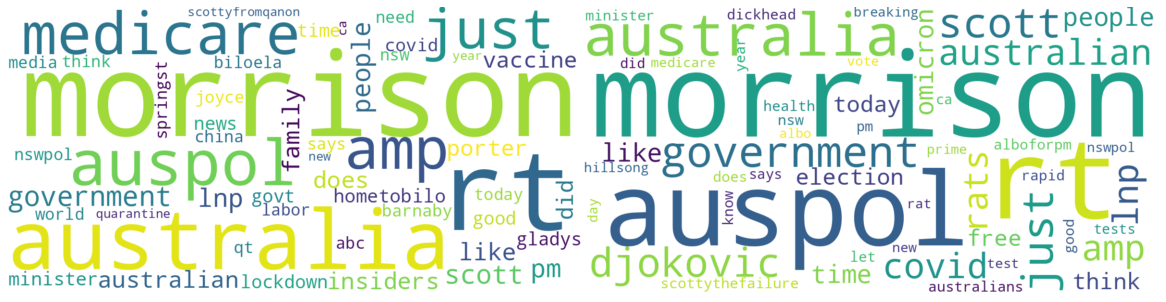

In [18]:
MAX_WORDS = 50
# METRIC = 'tf'
METRIC = 'tfidf'
wordclouds(corpora, ['jun21', 'jan22'], max_words=MAX_WORDS, metric=METRIC)

## Jux Polarity Wordcloud - term frequency

In [22]:
corpora['ju21'] = corpora['auspol'].slicer.filter_by_datetime('created_at', start='01-06-2021', end='01-08-2021')
# corpora['2022'] = auspol.slicer.filter_by_datetime('created_at', start='01-01-2022', end='01-01-2023')

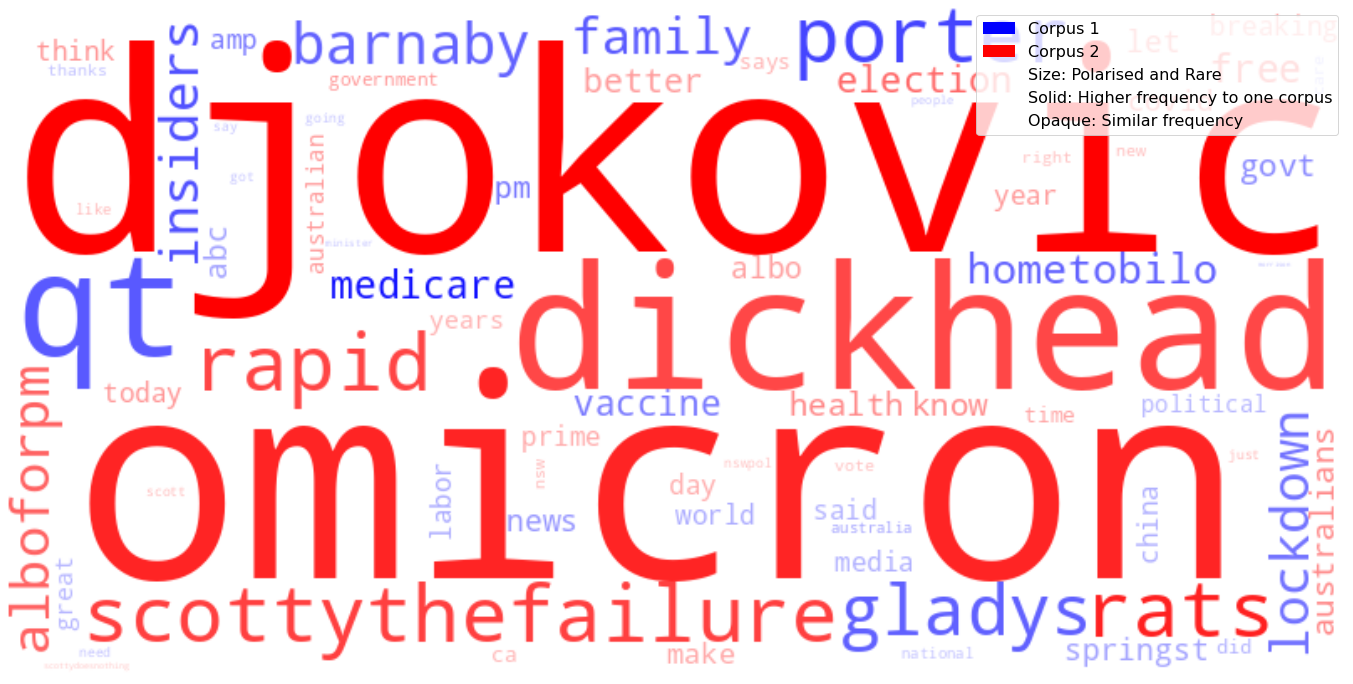

In [23]:
METRIC = 'tf'
# METRIC = 'tfidf'
# METRIC = 'log_likelihood'
TOP = 80
Jux(corpora['jun21'], corpora['jan22']).polarity.wordcloud(METRIC, top=TOP, colours=('blue', 'red'))

### User defined tokenising function

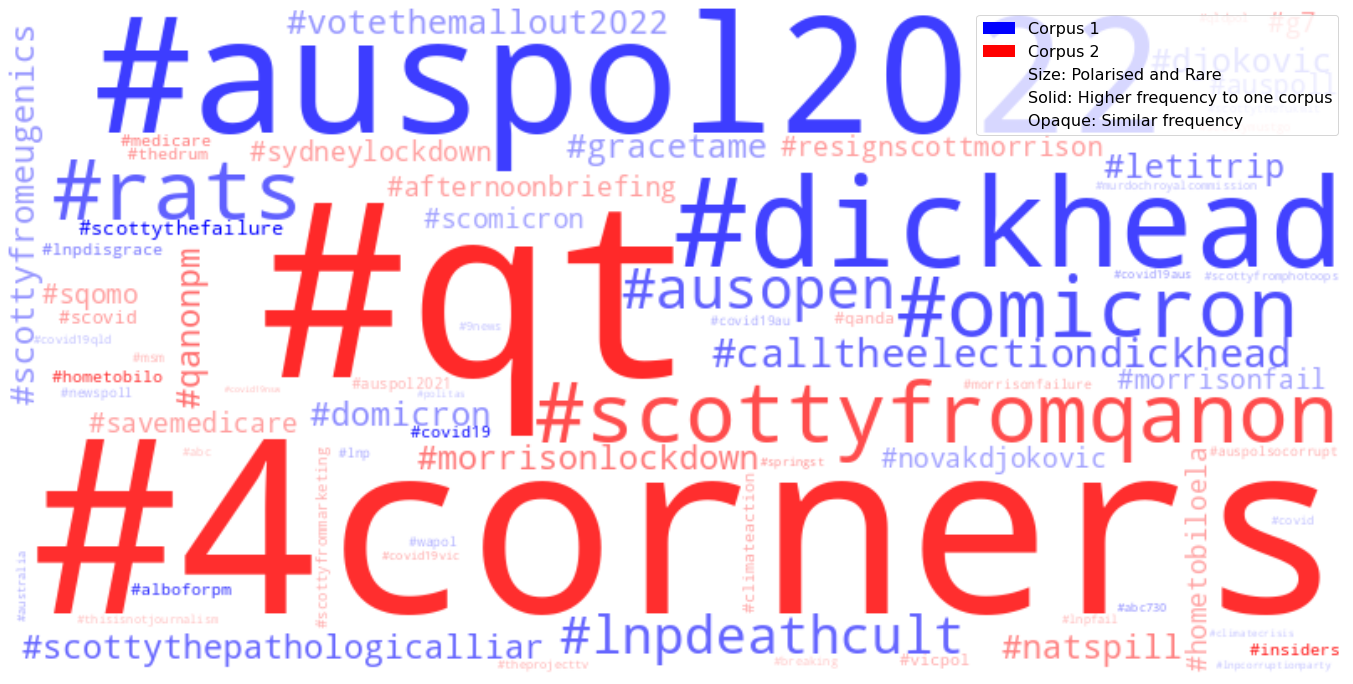

In [24]:
METRIC = 'tf'

# getting hashtags using a user defined function
Jux(corpora['jan22'], corpora['jun21']).\
    polarity.wordcloud(METRIC, top=TOP, colours=('blue', 'red'), tokeniser_func=extract_hashtags)

In [25]:
auspol = corpora['auspol']
corpora['android'] = auspol.slicer.filter_by_item('source', 'Twitter for Android')
corpora['iphone'] = auspol.slicer.filter_by_item('source', 'Twitter for iPhone')
corpora['2021'] = auspol.slicer.filter_by_datetime('created_at', start='01-01-2021', end='01-01-2022')
corpora['2022'] = auspol.slicer.filter_by_datetime('created_at', start='01-01-2022', end='01-01-2023')

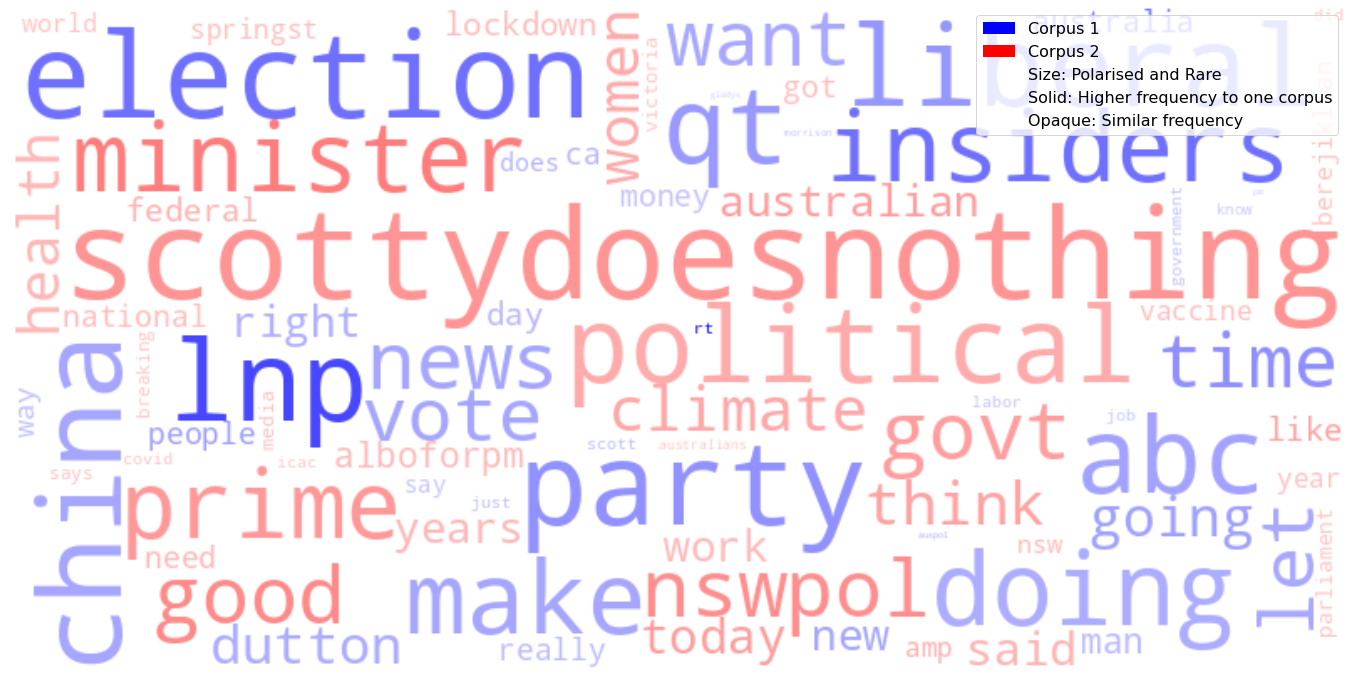

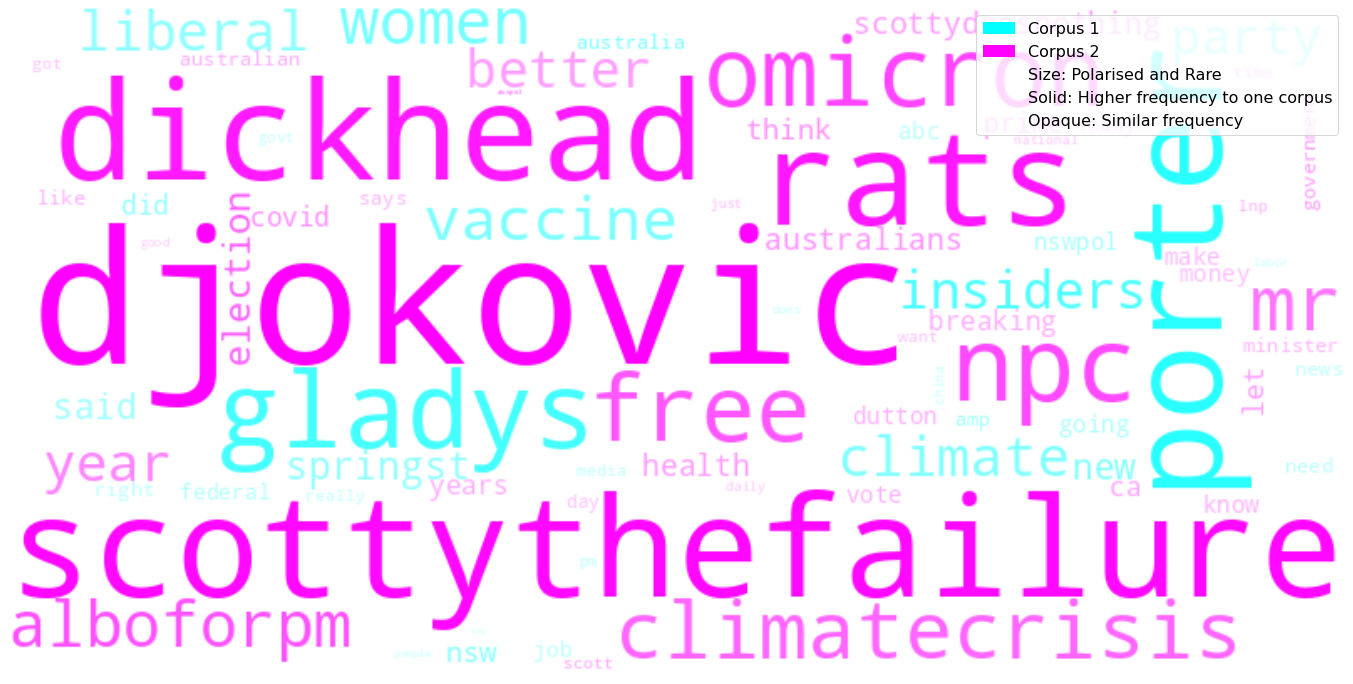

In [26]:
corpus_pairs = [
    ('android', 'iphone', ('blue', 'red')),
    ('2021', '2022', ('cyan', 'magenta')),
]

for pair in corpus_pairs:
    colours = pair[2]
    Jux(corpora[pair[0]], corpora[pair[1]]).polarity.wordcloud('tf', top=TOP, colours=colours)

# Keyword Analysis based on Log Likelihood

Future plans: using Log likelihood to analyse keywords (currently being integrated)


Rayson Paul., Berridge D. and Francis B. (2004). Extending the Cochran rule for the comparison of word frequencies between corpora. In Volume II of Purnelle G., Fairon C., Dister A. (eds.) Le poids des mots: Proceedings of the 7th International Conference on Statistical analysis of textual data (JADT 2004), Louvain-la-Neuve, Belgium, March 10-12, 2004, Presses universitaires de Louvain, pp. 926 - 936. ISBN 2-930344-50-4.
https://ucrel.lancs.ac.uk/llwizard.html

In [27]:
def style_corpus(row, colour):
    return ['color:blue;']*len(row) if colour[row.name] else ['color:red;']*len(row)

jun_ft = corpora['jun21'].dtm.freq_table().series
jan_ft = corpora['jan22'].dtm.freq_table().series
df_ft = pd.concat([jun_ft.rename('jun21'), jan_ft.rename('jan22')], axis=1, join='outer').fillna(0)
colour = df_ft['jun21'] > df_ft['jan22']

In [28]:
llv = Jux(corpora['jun21'], corpora['jan22']) \
    .stats.log_likelihood_and_effect_size() \
    .sort_values(by='log_likelihood_llv', ascending=False)
llv.iloc[:30].style \
    .apply(lambda row: style_corpus(row, colour), axis=1)

# Red - Overused in January Corpus, Blue - Overused in July Corpus

# Closing

+ Release is planned tentatively in **May**.
+ We will eventually integrate the ATAP tools together so you can easily access it under Corpus.
+ Stay tuned at https://www.atap.edu.au/
+ Feedback Survey at the end of the full workshop.
+ Questions - I'll be around or email me at huen.chan@sydney.edu.au